In [50]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode

# here's where we do ODEs
def double_pendulum():
    '''Simulates two pendulum system'''
    # ------------define intial condition-----------
    # form of
        # theta1 rad
        # omega1 rad/s
        # theta2 rad
        # omega2 rad/s
        # Y m
        # V m/s
    x0 = np.array([[.25],
                   [0],
                   [.25],
                   [0],
                   [0],
                   [0]])
    t0 = 0
    
    # --------------------ODE--------------------
    # set integration method
    r = ode(derivs).set_integrator('dopri5')
    
    # set intitial value
    r.set_initial_value(x0, t0)
    
    # define ending time and time increment
    t_end = 160 # s
    dt = 1 # s
    
    # run ODE
    t = []
    x = []
    while r.successful() and r.t < t_end:
        t.append(r.t+dt)
        x.append(r.integrate(r.t+dt))
    
    #print x
    organized_data = organize_data(x)
    #print organized_data

    # -----------------plot----------------------
    theta_1 = organized_data[0]
    #print(theta_1)
    omega_1 = organized_data[1]
    theta_2 = organized_data[2]
    omega_2 = organized_data[3]
    Y = organized_data[4]
    V = organized_data[5]
    
    plt.plot(t, theta_1, 'r', t, theta_2, 'b')

    plt.show()
    
    
def organize_data(data):
    '''organizes list of arrays into lists of values'''
    theta_1 = []
    omega_1 = []
    theta_2 = []
    omega_2 = []
    Y = []
    V = []
    for data_point in data:
        theta_1.append(data_point[0])
        omega_1.append(data_point[1])
        theta_2.append(data_point[2])
        omega_2.append(data_point[3])
        Y.append(data_point[4])
        V.append(data_point[5])
    
    return theta_1, omega_1, theta_2, omega_2, Y, V


def derivs(t,x):
    '''function to compute right hand side of 
    differential equation
    X is matrix with values: theta_1, omega'''
    # TODO: add escapement force for pendulum 1
    # TODO: add escapement force for pendulum 2
    
    # define constants
    mass_pendulum = .043 # kg
    mass_cart = 3.45 # kg
    length_pendulum = .2 # m
    gravity = 9.8 # m/s^2
    spring_constant = 3.4 # N/m
    little_b = .005
    big_b = .005
    
    mass_ratio = mass_cart + 2*mass_pendulum
    
    mu = mass_pendulum/mass_ratio
    little_gamma = (little_b*math.sqrt(length_pendulum/4*gravity))/mass_ratio
    big_gamma = (big_b*math.sqrt(length_pendulum/4*gravity))/mass_ratio
    omega = spring_constant/mass_ratio
    
    # system of equations
    A = np.array([[1,0,0,0,0,0],
                  [0,1,0,0,0,1],
                  [0,0,1,0,0,0],
                  [0,0,0,1,0,1],
                  [0,0,0,0,1,0],
                  [0,mu,0,mu,0,1]])
    B = np.array([[0,1,0,0,0,0],
                  [-1,-2*little_gamma,0,0,0,0],
                  [0,0,0,1,0,0],
                  [0,0,-1,-2*little_gamma,0,0],
                  [0,0,0,0,0,1],
                  [0,0,0,0,-omega**2,-2*big_gamma]])
    
    # return derivatives
    right_side = np.matmul(B,x)
    dxdt = np.matmul(right_side, A.transpose())
    return dxdt

def force_escape(x,v):
    '''computes force of escapement given
        x: x position
        v: computed velocity at that point'''
    pass

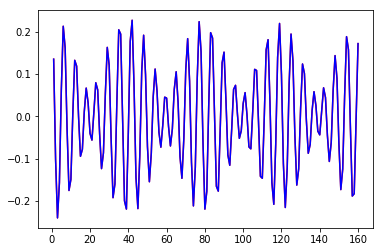

In [51]:
double_pendulum()

### Links
[scipy ODE](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html)

[Matlab to Python equivelants](https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html)